In [1]:
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from collections import Counter

import pandas as pd
import numpy as np

In [2]:
#settings
EPOCHS = 10
BATCH_SIZE = 128
CLASS_WEIGHT=[0.04, 0.94, 0.02]
HIDDEN_DIM=64
#
MAX_LEN = 400

# Data Upload

In [4]:
df = pd.read_csv('HateSpeechTurkish.csv', encoding="utf-8-sig")

In [5]:
#df = df.head(1000)

In [6]:
history = {'loss': [], 'f1': [], 'val_loss': [], 'val_f1': []}

In [7]:
main_result = {'model_name': [],
               'Accuracy': [], 'Precision': [], 'Recall': [] , 'F1': [],
               'Train_Time': [] , 'Infer_Time': []}

In [8]:
if df.isnull().values.any():
    print(df.isnull().sum())
    df.dropna(inplace=True)

row_id                      0
tweet                       0
etiket                     55
corrected_tweet             0
correct_normalize_tweet     0
dtype: int64


In [9]:
print("After drop null value:")
print(df.isnull().sum())

After drop null value:
row_id                     0
tweet                      0
etiket                     0
corrected_tweet            0
correct_normalize_tweet    0
dtype: int64


In [10]:
df['etiket'].value_counts()

etiket
hiçbiri      7667
nefret       2336
saldırgan     166
Name: count, dtype: int64

In [11]:
print("Original data class distribution:", Counter(df['etiket']))

Original data class distribution: Counter({'hiçbiri': 7667, 'nefret': 2336, 'saldırgan': 166})


In [12]:
label_mapping={
 'nefret':     0,
 'saldırgan':  1,
 'hiçbiri':    2,
}

In [13]:
y = df['etiket'].map(label_mapping)

In [14]:
x = df['correct_normalize_tweet']

# FT-TRW2V(FineTune turkish Word2Vec)

In [16]:
from gensim.models import KeyedVectors

path = "embedding/trmodel_finetune.kv"  # değiştir!
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True)
emb_dim = w2v_model.vector_size

In [17]:
print(emb_dim)

400


# NLP

In [19]:
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]
PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN = special_tokens
PAD_IDX, SOS_IDX, EOS_IDX, UNK_IDX = 0, 1, 2, 3

In [20]:
tokenized_sentences = [sentence.split() for sentence in x]
all_tokens = [token for sent in tokenized_sentences for token in sent]
vocab = special_tokens + sorted(set(all_tokens))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}


In [21]:
import numpy as np
import torch

embedding_matrix = np.zeros((len(word2idx), emb_dim))
for word, idx in word2idx.items():
    if word in w2v_model:
        embedding_matrix[idx] = w2v_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(emb_dim,))
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

In [22]:
def encode_sentence(sentence, word2idx, max_len):
    tokens = sentence.split()
    indices = [word2idx.get(w, UNK_IDX) for w in tokens]
    indices = [SOS_IDX] + indices + [EOS_IDX]
    if len(indices) < max_len:
        indices += [PAD_IDX] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices


encoded_data = [encode_sentence(sent, word2idx, MAX_LEN) for sent in x]


X = encoded_data

# Test train split

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=42)
print("x_train",len(X_train))
print("x_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("Number of unique classes in y_test:",len(set(y_test)))

x_train 9152
x_test 1017
y_train 9152
y_test 1017
Number of unique classes in y_test: 3


In [25]:
src_tensor = torch.tensor(X_train, dtype=torch.long)
trg_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
src_tensor_test = torch.tensor(X_test, dtype=torch.long)
trg_tensor_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
sample = torch.tensor(X_test[10:11], dtype=torch.long).to(device)  # Sample for inferece time test

cuda


In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(src_tensor, trg_tensor)
val_dataset = TensorDataset(src_tensor_test, trg_tensor_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# AdditiveAttention + FT-W2V

In [29]:
model_name='bahdanau_FT-W2V'

In [30]:
OUTPUT_DIM =len(set(y))

In [31]:
from transformer_model.attention import AdditiveAttention
from train.trainSeq2Seq import train_seq2seq_model



attention = AdditiveAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0866, F1: 0.2550 | Val_Loss: 1.0838, Val_F1: 0.2356
Epoch 02 | Loss: 1.0740, F1: 0.2954 | Val_Loss: 1.0517, Val_F1: 0.4038
Epoch 03 | Loss: 0.9583, F1: 0.4321 | Val_Loss: 0.9405, Val_F1: 0.4171
Epoch 04 | Loss: 0.6788, F1: 0.5466 | Val_Loss: 1.1834, Val_F1: 0.4142
Epoch 05 | Loss: 0.4165, F1: 0.6659 | Val_Loss: 1.2336, Val_F1: 0.5119
Epoch 06 | Loss: 0.2261, F1: 0.7929 | Val_Loss: 1.3371, Val_F1: 0.4595
Epoch 07 | Loss: 0.1492, F1: 0.8503 | Val_Loss: 1.8173, Val_F1: 0.5224
Epoch 08 | Loss: 0.1048, F1: 0.9168 | Val_Loss: 2.3885, Val_F1: 0.5071
Epoch 09 | Loss: 0.0725, F1: 0.9313 | Val_Loss: 2.1801, Val_F1: 0.5115
Epoch 10 | Loss: 0.0608, F1: 0.9434 | Val_Loss: 2.6518, Val_F1: 0.5044

✅ Model saved to: models/bahdanau_FT-W2V.pt


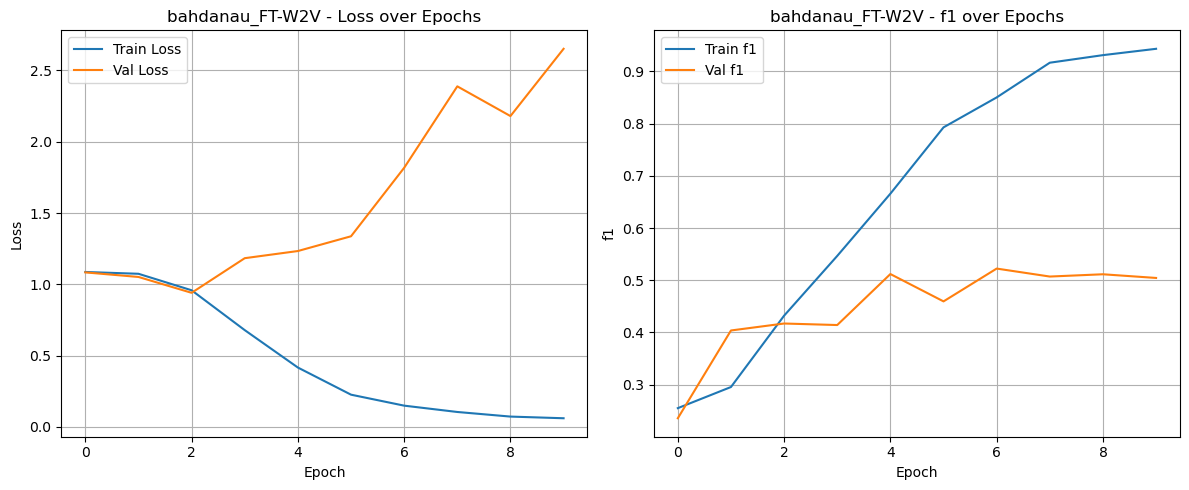

📈 Training history saved to: plots/saved/bahdanau_FT-W2V_plot.png


In [32]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FT-W2V
Accuracy  : 0.8063
Precision : 0.5016
Recall    : 0.5080
F1 Score  : 0.5044


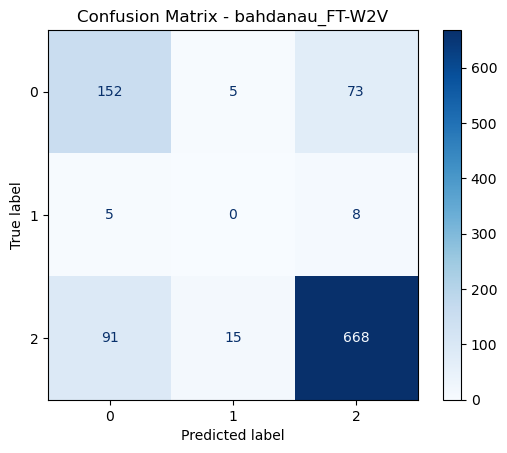

📌 Confusion matrix saved to: plots/saved/bahdanau_FT-W2V_csmtx.png


In [33]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [34]:
def test_inference(model,sample):
    start_infer = time.time()
    
    with torch.no_grad():
        output = model(sample)
        pred = output.argmax(dim=1).item()
        
    end_infer = time.time()
    
    infer_time = (end_infer - start_infer )* 1000
    
    print(f"\n🧠 Prediction for sample #10: Class {pred}")
    print(f"⚡ Inference Time for one sample : {infer_time:.2f} ms")
    return infer_time

In [35]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.12 ms


In [36]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

In [37]:
main_result

{'model_name': ['bahdanau_FT-W2V'],
 'Accuracy': [0.8062930186823992],
 'Precision': [0.5015863445167033],
 'Recall': [0.5079728869415422],
 'F1': [0.5043997615364962],
 'Train_Time': [19954.092741012573],
 'Infer_Time': [1.1203289031982422]}

# AdditiveAttention + FreeEmbedding

In [39]:
model_name='bahdanau_FE'

In [40]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0922, F1: 0.2648 | Val_Loss: 1.0733, Val_F1: 0.2876
Epoch 02 | Loss: 0.9906, F1: 0.3887 | Val_Loss: 0.8968, Val_F1: 0.4327
Epoch 03 | Loss: 0.6288, F1: 0.5112 | Val_Loss: 1.0341, Val_F1: 0.4823
Epoch 04 | Loss: 0.3714, F1: 0.6890 | Val_Loss: 1.3320, Val_F1: 0.4909
Epoch 05 | Loss: 0.2523, F1: 0.8245 | Val_Loss: 1.8898, Val_F1: 0.5496
Epoch 06 | Loss: 0.1589, F1: 0.9139 | Val_Loss: 2.4002, Val_F1: 0.5538
Epoch 07 | Loss: 0.0830, F1: 0.9650 | Val_Loss: 2.9740, Val_F1: 0.5268
Epoch 08 | Loss: 0.0291, F1: 0.9888 | Val_Loss: 3.5149, Val_F1: 0.5361
Epoch 09 | Loss: 0.0169, F1: 0.9942 | Val_Loss: 3.8721, Val_F1: 0.5330
Epoch 10 | Loss: 0.0125, F1: 0.9954 | Val_Loss: 4.3308, Val_F1: 0.5598

✅ Model saved to: models/bahdanau_FE.pt


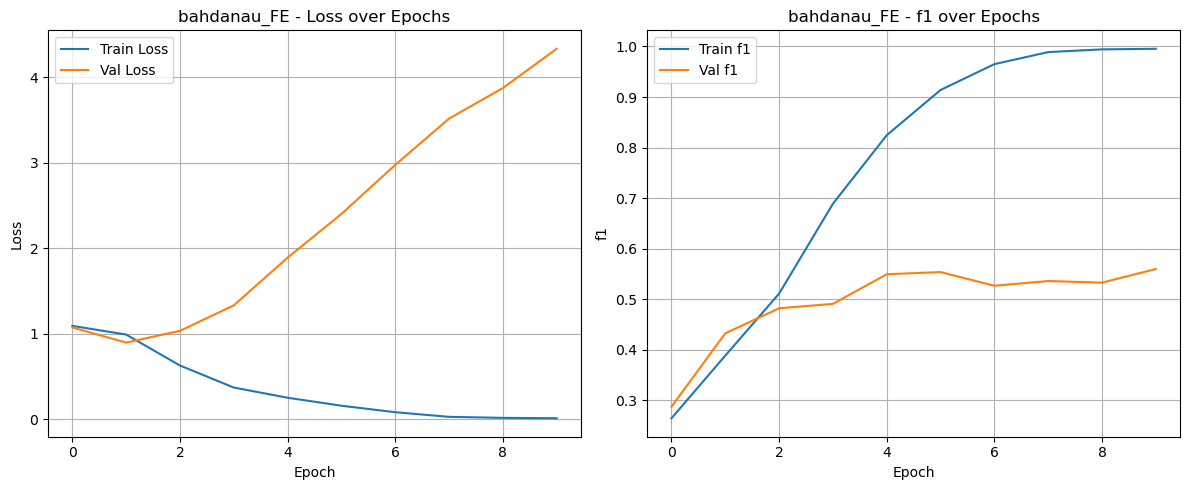

📈 Training history saved to: plots/saved/bahdanau_FE_plot.png


In [41]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - bahdanau_FE
Accuracy  : 0.8230
Precision : 0.5867
Recall    : 0.5413
F1 Score  : 0.5598


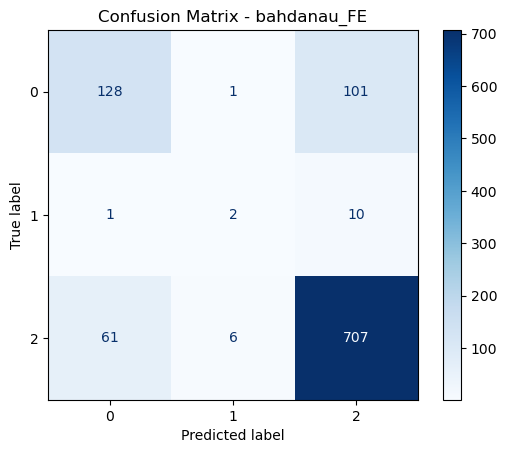

📌 Confusion matrix saved to: plots/saved/bahdanau_FE_csmtx.png


In [42]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [43]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [44]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FT-W2V

In [46]:
model_name='Luong_FT-W2V'

In [47]:
from transformer_model.attention import DotProductAttention
attention = DotProductAttention()

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0981, F1: 0.2633 | Val_Loss: 1.0662, Val_F1: 0.2881
Epoch 02 | Loss: 1.0532, F1: 0.3258 | Val_Loss: 1.0235, Val_F1: 0.3892
Epoch 03 | Loss: 0.9112, F1: 0.4076 | Val_Loss: 1.0378, Val_F1: 0.3885
Epoch 04 | Loss: 0.6866, F1: 0.4978 | Val_Loss: 1.1794, Val_F1: 0.4486
Epoch 05 | Loss: 0.4234, F1: 0.6525 | Val_Loss: 1.6459, Val_F1: 0.4809
Epoch 06 | Loss: 0.2607, F1: 0.7598 | Val_Loss: 2.1088, Val_F1: 0.4903
Epoch 07 | Loss: 0.1366, F1: 0.8858 | Val_Loss: 2.2362, Val_F1: 0.4850
Epoch 08 | Loss: 0.0902, F1: 0.9190 | Val_Loss: 2.2932, Val_F1: 0.4934
Epoch 09 | Loss: 0.0556, F1: 0.9607 | Val_Loss: 3.1359, Val_F1: 0.4990
Epoch 10 | Loss: 0.0579, F1: 0.9436 | Val_Loss: 2.5942, Val_F1: 0.5043

✅ Model saved to: models/Luong_FT-W2V.pt


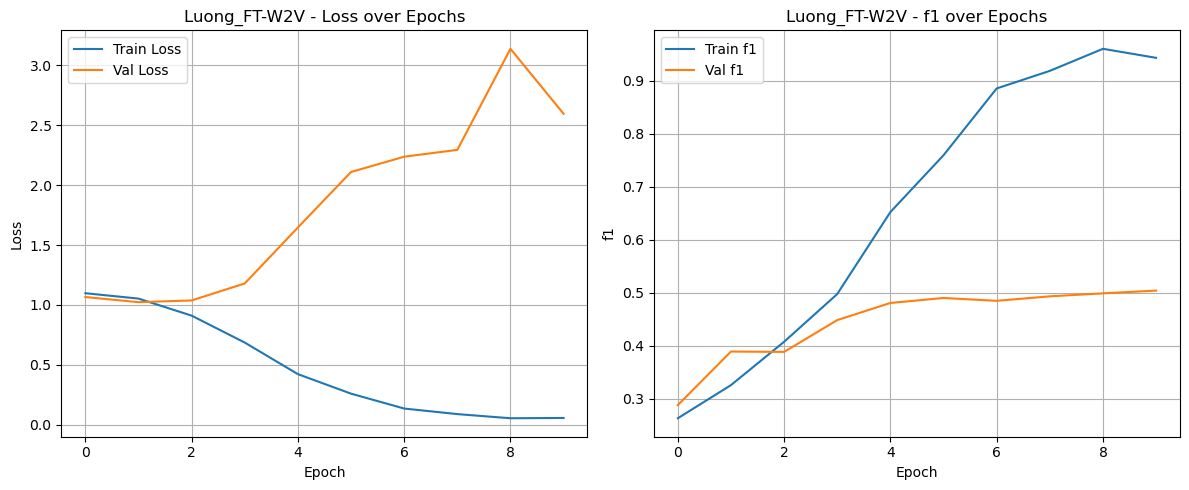

📈 Training history saved to: plots/saved/Luong_FT-W2V_plot.png


In [48]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FT-W2V
Accuracy  : 0.7748
Precision : 0.5194
Recall    : 0.5222
F1 Score  : 0.5043


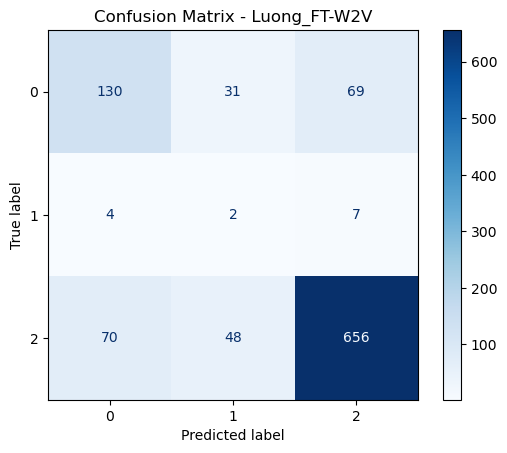

📌 Confusion matrix saved to: plots/saved/Luong_FT-W2V_csmtx.png


In [49]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [50]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 1.87 ms


In [51]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# DotProduct + FE

In [53]:
model_name='Luong_FE'

In [54]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0882, F1: 0.2510 | Val_Loss: 1.0696, Val_F1: 0.2848
Epoch 02 | Loss: 0.9902, F1: 0.3441 | Val_Loss: 1.0592, Val_F1: 0.3641
Epoch 03 | Loss: 0.6252, F1: 0.5049 | Val_Loss: 1.2454, Val_F1: 0.4996
Epoch 04 | Loss: 0.3950, F1: 0.6909 | Val_Loss: 1.6594, Val_F1: 0.4928
Epoch 05 | Loss: 0.2759, F1: 0.8143 | Val_Loss: 1.8557, Val_F1: 0.5522
Epoch 06 | Loss: 0.1854, F1: 0.8798 | Val_Loss: 2.0026, Val_F1: 0.5457
Epoch 07 | Loss: 0.1082, F1: 0.9411 | Val_Loss: 2.2457, Val_F1: 0.5680
Epoch 08 | Loss: 0.0556, F1: 0.9751 | Val_Loss: 2.6128, Val_F1: 0.5478
Epoch 09 | Loss: 0.0318, F1: 0.9861 | Val_Loss: 3.1844, Val_F1: 0.5616
Epoch 10 | Loss: 0.0314, F1: 0.9884 | Val_Loss: 2.9310, Val_F1: 0.5770

✅ Model saved to: models/Luong_FE.pt


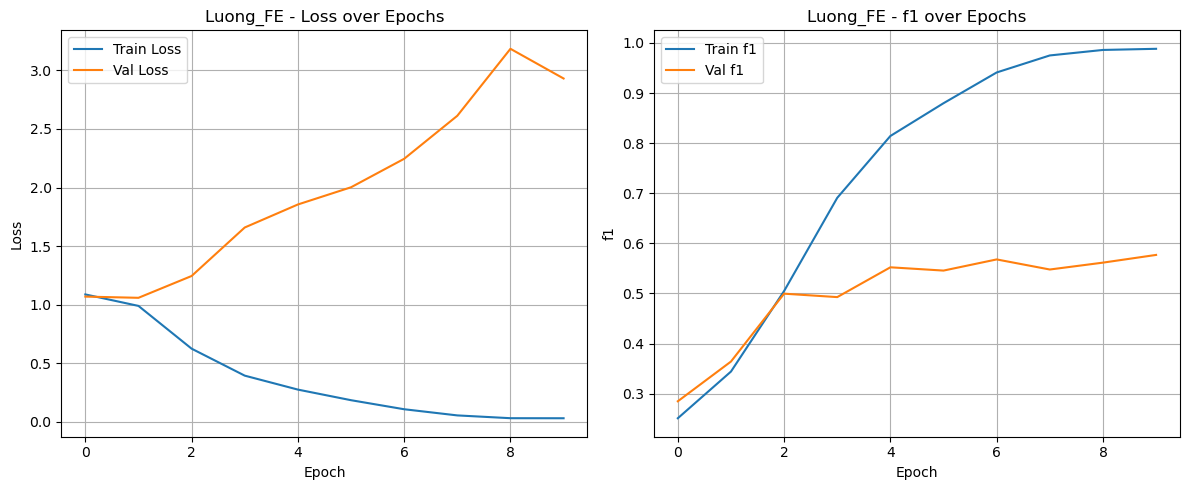

📈 Training history saved to: plots/saved/Luong_FE_plot.png


In [55]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - Luong_FE
Accuracy  : 0.8112
Precision : 0.6065
Recall    : 0.5562
F1 Score  : 0.5770


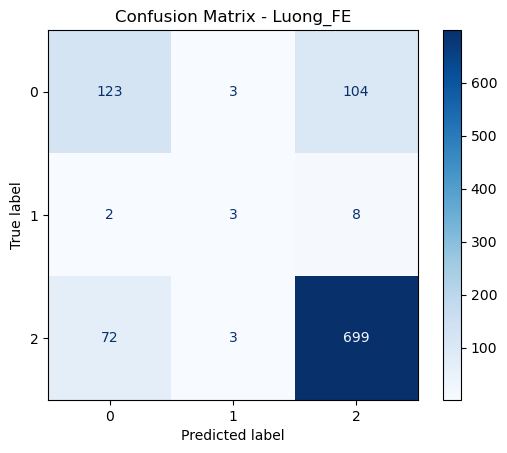

📌 Confusion matrix saved to: plots/saved/Luong_FE_csmtx.png


In [56]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [57]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [58]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FT-W2V

In [60]:
model_name='scaled-dot_FT-W2V'

In [61]:
from transformer_model.attention import ScaledDotProductAttention
attention = ScaledDotProductAttention(hidden_dim=HIDDEN_DIM)

model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=embedding_matrix,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0821, F1: 0.2639 | Val_Loss: 1.0813, Val_F1: 0.2514
Epoch 02 | Loss: 1.0705, F1: 0.2823 | Val_Loss: 1.0538, Val_F1: 0.2688
Epoch 03 | Loss: 0.9723, F1: 0.4133 | Val_Loss: 0.9786, Val_F1: 0.4287
Epoch 04 | Loss: 0.6511, F1: 0.5706 | Val_Loss: 1.0422, Val_F1: 0.4946
Epoch 05 | Loss: 0.3654, F1: 0.7092 | Val_Loss: 1.1800, Val_F1: 0.5169
Epoch 06 | Loss: 0.2009, F1: 0.8021 | Val_Loss: 1.8119, Val_F1: 0.5227
Epoch 07 | Loss: 0.1464, F1: 0.8718 | Val_Loss: 2.1830, Val_F1: 0.5087
Epoch 08 | Loss: 0.0718, F1: 0.9379 | Val_Loss: 2.4731, Val_F1: 0.5092
Epoch 09 | Loss: 0.0600, F1: 0.9409 | Val_Loss: 3.1235, Val_F1: 0.4830
Epoch 10 | Loss: 0.0703, F1: 0.9330 | Val_Loss: 2.9142, Val_F1: 0.5034

✅ Model saved to: models/scaled-dot_FT-W2V.pt


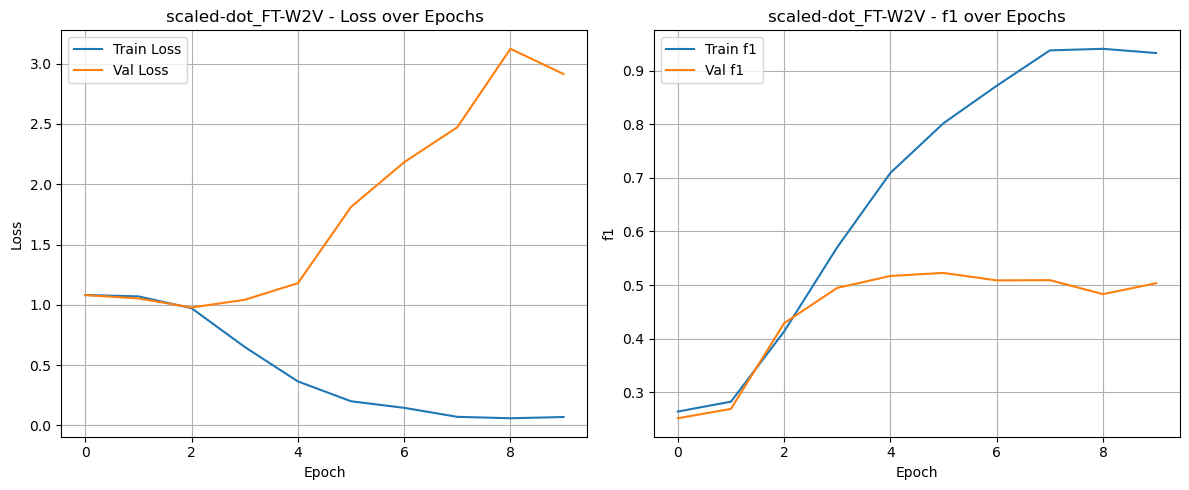

📈 Training history saved to: plots/saved/scaled-dot_FT-W2V_plot.png


In [62]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FT-W2V
Accuracy  : 0.8063
Precision : 0.5070
Recall    : 0.4998
F1 Score  : 0.5034


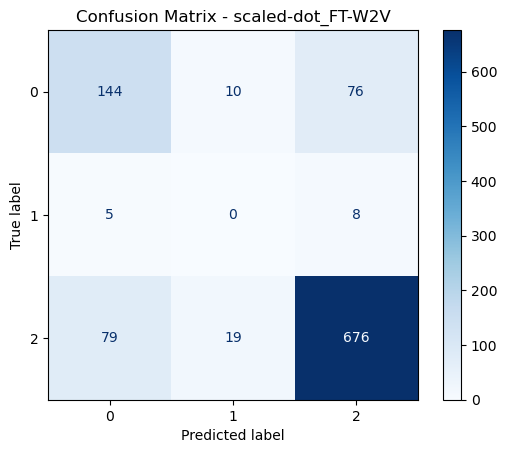

📌 Confusion matrix saved to: plots/saved/scaled-dot_FT-W2V_csmtx.png


In [63]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [64]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [65]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# Scaled-dotProduct + FE

In [67]:
model_name='scaled-dot_FE'

In [68]:
model, history, train_time = train_seq2seq_model(
    attention_module=attention,
    embedding_matrix=None,
    word2idx=word2idx,
    output_dim=OUTPUT_DIM,
    train_loader=train_loader,
    val_loader=val_loader,
    PAD_IDX=PAD_IDX,
    model_name=model_name,
    embedding_dim=emb_dim,
    hidden_dim=HIDDEN_DIM,
    EPOCHS=EPOCHS,
    CLASS_W=CLASS_WEIGHT,
)

Epoch 01 | Loss: 1.0826, F1: 0.2585 | Val_Loss: 1.0936, Val_F1: 0.1736
Epoch 02 | Loss: 0.9931, F1: 0.3209 | Val_Loss: 0.9964, Val_F1: 0.3707
Epoch 03 | Loss: 0.6629, F1: 0.4899 | Val_Loss: 1.0552, Val_F1: 0.4402
Epoch 04 | Loss: 0.4179, F1: 0.6575 | Val_Loss: 1.5101, Val_F1: 0.5026
Epoch 05 | Loss: 0.2666, F1: 0.8233 | Val_Loss: 2.1293, Val_F1: 0.4867
Epoch 06 | Loss: 0.1656, F1: 0.9084 | Val_Loss: 2.5325, Val_F1: 0.5241
Epoch 07 | Loss: 0.0791, F1: 0.9640 | Val_Loss: 3.0140, Val_F1: 0.5004
Epoch 08 | Loss: 0.0322, F1: 0.9870 | Val_Loss: 3.2172, Val_F1: 0.4990
Epoch 09 | Loss: 0.0169, F1: 0.9931 | Val_Loss: 3.6356, Val_F1: 0.5023
Epoch 10 | Loss: 0.0131, F1: 0.9937 | Val_Loss: 3.7651, Val_F1: 0.5058

✅ Model saved to: models/scaled-dot_FE.pt


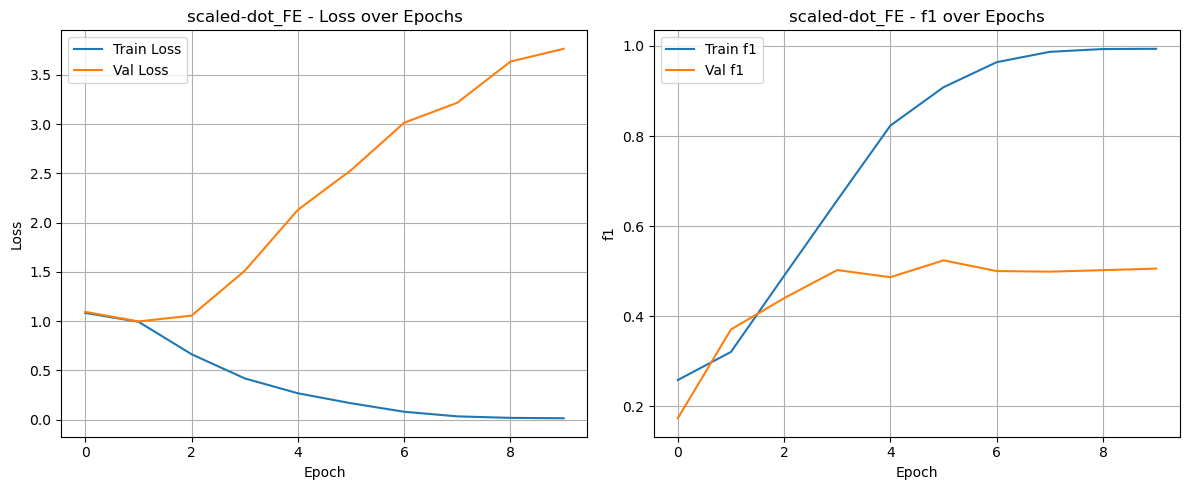

📈 Training history saved to: plots/saved/scaled-dot_FE_plot.png


In [69]:
from plots.loss_val_plot import plot_training_history

plot_training_history(history, model_name=model_name)


🔍 Test Metrikleri - scaled-dot_FE
Accuracy  : 0.8151
Precision : 0.5069
Recall    : 0.5047
F1 Score  : 0.5058


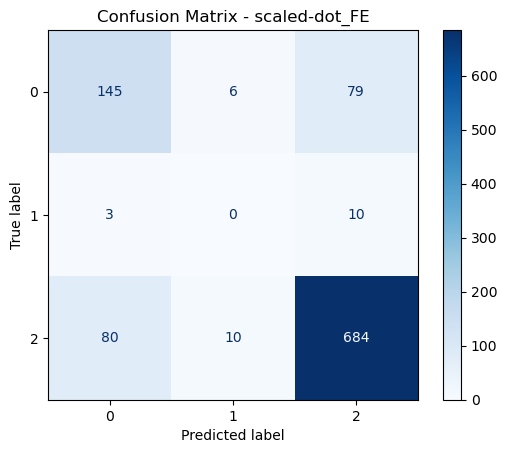

📌 Confusion matrix saved to: plots/saved/scaled-dot_FE_csmtx.png


In [70]:
from plots.eval_plot_conf_mtx import evaluate_and_plot_confusion_matrix

metrics = evaluate_and_plot_confusion_matrix(
    model=model,
    src_tensor=src_tensor_test,
    trg_tensor=trg_tensor_test,
    device=device,
    model_name=model_name
)

In [71]:
infer_time = test_inference(model,sample)


🧠 Prediction for sample #10: Class 2
⚡ Inference Time for one sample : 0.00 ms


In [72]:
[main_result[k].append(v) for k, v in zip(['model_name',
                                           'Accuracy', 'Precision', 'Recall','F1',
                                           'Train_Time','Infer_Time'], [model_name,
                                                                       metrics['accuracy'], metrics['precision'], metrics['recall'],metrics['f1'],
                                                                      train_time, infer_time])]


[None, None, None, None, None, None, None]

# result

In [74]:
main_result

{'model_name': ['bahdanau_FT-W2V',
  'bahdanau_FE',
  'Luong_FT-W2V',
  'Luong_FE',
  'scaled-dot_FT-W2V',
  'scaled-dot_FE'],
 'Accuracy': [0.8062930186823992,
  0.8230088495575221,
  0.7748279252704031,
  0.8112094395280236,
  0.8062930186823992,
  0.8151425762045231],
 'Precision': [0.5015863445167033,
  0.5867365370775485,
  0.5193737077911512,
  0.6065325686085918,
  0.5070175438596491,
  0.5069430259564393],
 'Recall': [0.5079728869415422,
  0.5412681951610162,
  0.5222029215962481,
  0.5562175382195605,
  0.4998239898138786,
  0.5047185709470846],
 'F1': [0.5043997615364962,
  0.5598443153719536,
  0.5042711571380697,
  0.5769528707833512,
  0.5033922976340266,
  0.5058266504451966],
 'Train_Time': [19954.092741012573,
  19177.499532699585,
  18881.399869918823,
  18626.460313796997,
  18555.386066436768,
  19014.983654022217],
 'Infer_Time': [1.1203289031982422, 0.0, 1.8665790557861328, 0.0, 0.0, 0.0]}

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Model Performance Metrics'}, ylabel='Value'>,
  <Axes: title={'center': 'Model Training and Inference Times'}, xlabel='Model', ylabel='Training Time (seconds)'>,
  <Axes: ylabel='Inference Time (seconds)'>))

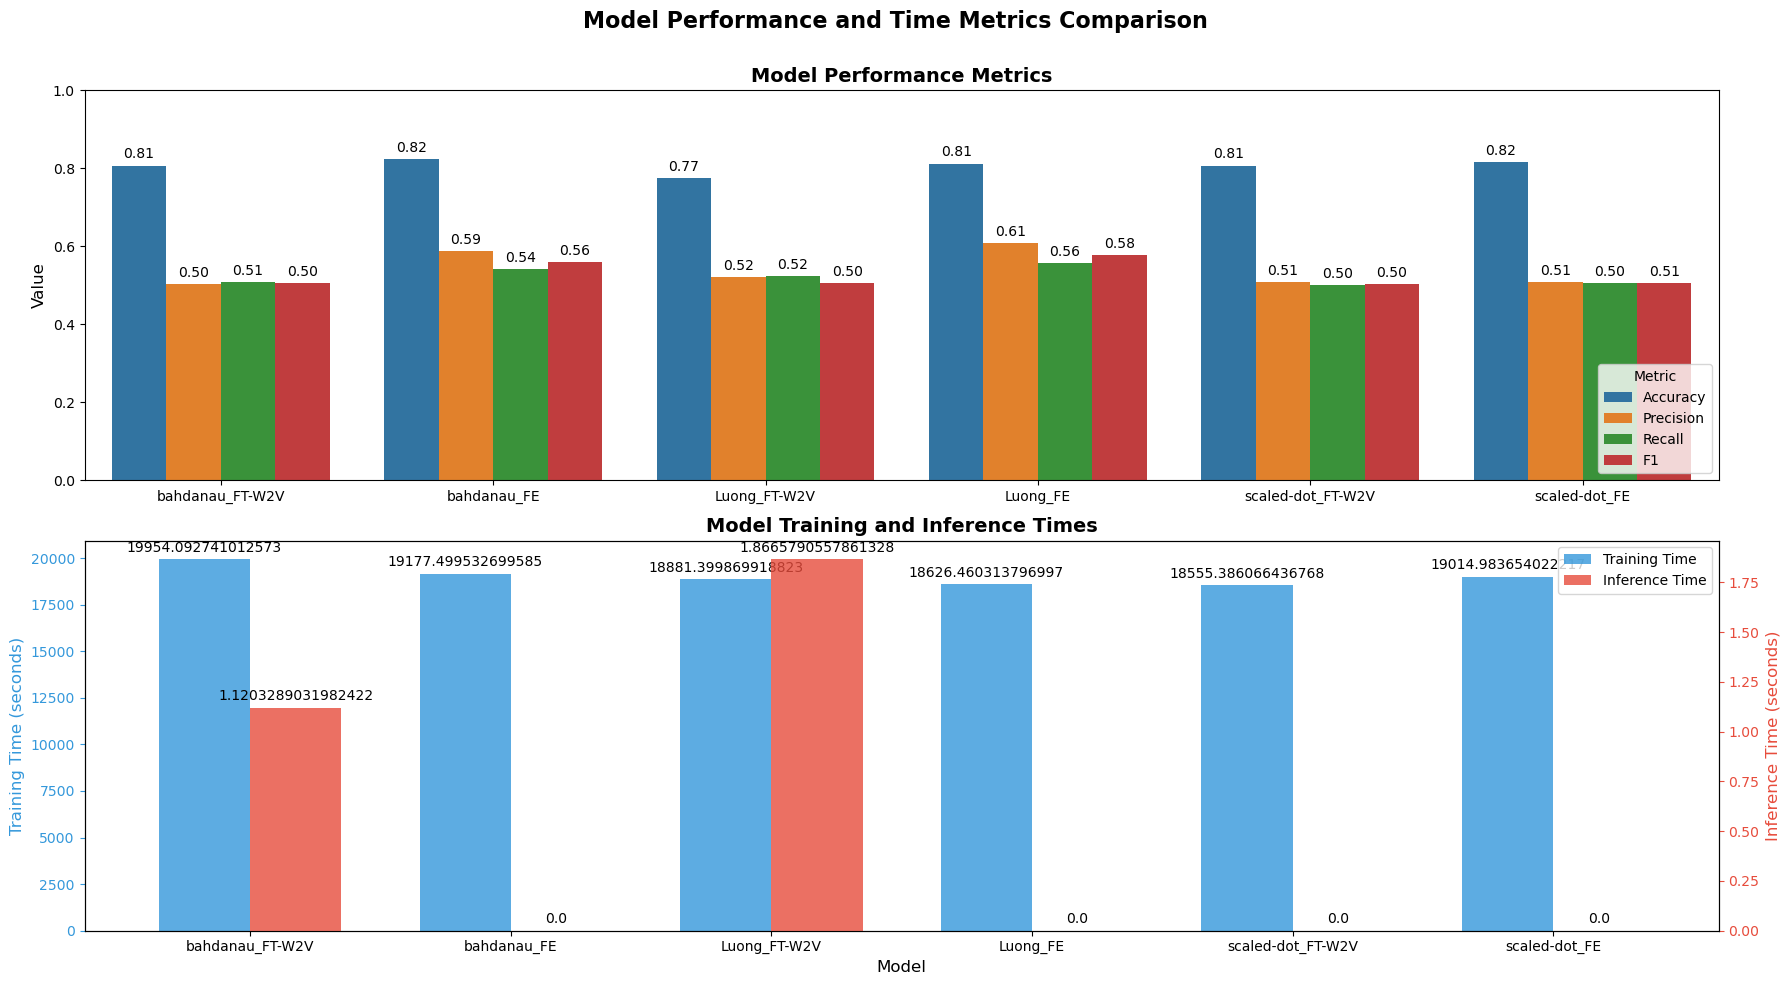

In [75]:
from plots.time_metric import plot_all_model_metrics

plot_all_model_metrics(main_result)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Model Performance Metrics Comparison'}, xlabel='Model', ylabel='Value'>)

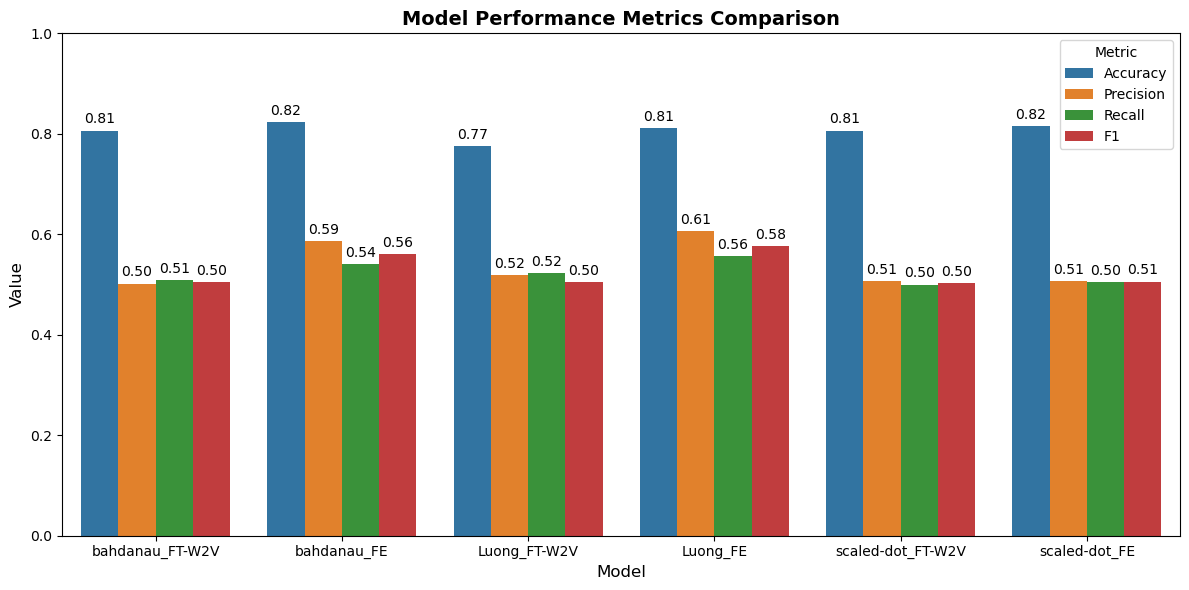

In [76]:
from plots.time_metric import plot_performance_metrics
plot_performance_metrics(main_result)

In [77]:
# AdditiveAttention + FT-W2V